### *Cell 1 — Markdown (what this notebook does)*~ 

# Notebook 01 — Data Inventory & Quality Audit

## Purpose
This notebook audits all raw Lake Victoria input datasets (lake level, outflow, rainfall, evaporation,
and tributary inflows) to establish:

- Column schema consistency
- Date parsing correctness (including mixed DD/MM/YYYY and MM/DD/YYYY)
- Time coverage (start/end) and inferred frequency (daily/monthly/irregular)
- Missingness rates (overall and through time)
- Common overlapping period for core daily lake modeling

## Key outputs (saved automatically)
- outputs/tables/data_inventory_report.csv
- outputs/figures/01_time_coverage.png
- outputs/figures/01_missingness_heatmap.png
- outputs/figures/01_preview_*.png
- data/processed/audit_daily_core_variables.csv

## Thesis link (Chapter 4)
These results support the section: "Data overview and quality assessment",
and justify the chosen modeling period and preprocessing decisions.


### *Cell 2 — Imports + paths (PEP-8)*

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# Project paths
# ----------------------------
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TABLE_DIR = PROJECT_ROOT / "outputs" / "tables"

for folder in [PROCESSED_DIR, FIG_DIR, TABLE_DIR]:
    folder.mkdir(parents=True, exist_ok=True)


# ----------------------------
# File paths (match your exact filenames)
# ----------------------------
FILE_MAP = {
    "lake_levels_jinja": RAW_DIR / "Water_levels_at_Jinja.csv",
    "victoria_nile_outflows": RAW_DIR / "Victoria_Nile_Out_Flows.csv",
    "lake_evaporation": RAW_DIR / "Lake_Victoria_Daily_Evaporation_2001_2023.csv",
    "chirps_rainfall": RAW_DIR / "CHIRPS_daily_precipitation.csv",
}

TRIBUTARY_DIR = RAW_DIR / "tributary_15_inflows"


### *Cell 3 — Safe date parsing (handles mixed DD/MM and MM/DD)*

In [2]:
def _try_parse_dates(s: pd.Series, dayfirst: bool) -> pd.Series:
    """Try parsing dates with a specific dayfirst setting."""
    return pd.to_datetime(s, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)


def parse_date_series(date_series: pd.Series) -> pd.DatetimeIndex:
    """
    Parse dates robustly when the dataset contains mixed formats such as:
    - 01/12/1956 (could be DD/MM or MM/DD)
    - 1/13/1956 (must be MM/DD)

    Strategy:
    - Try parsing with dayfirst=False and dayfirst=True
    - Select the parse that yields fewer NaT values
    """
    s = date_series.astype(str).str.strip()

    dt_mdy = _try_parse_dates(s, dayfirst=False)  # month-first
    dt_dmy = _try_parse_dates(s, dayfirst=True)   # day-first

    mdy_nat = dt_mdy.isna().mean()
    dmy_nat = dt_dmy.isna().mean()

    if (mdy_nat == 1.0) and (dmy_nat == 1.0):
        bad = s.head(10).tolist()
        raise ValueError(f"Date parsing failed completely. Examples: {bad}")

    dt = dt_mdy if mdy_nat <= dmy_nat else dt_dmy

    if dt.isna().any():
        bad = s[dt.isna()].head(10).tolist()
        raise ValueError(
            "Date parsing failed for some rows. Examples of problematic values:\n"
            f"{bad}"
        )

    return pd.DatetimeIndex(dt)


def infer_time_frequency(dt_index: pd.DatetimeIndex) -> str:
    """Infer frequency (daily/monthly/irregular) from the datetime index."""
    if len(dt_index) < 5:
        return "unknown"

    dt_index = pd.DatetimeIndex(dt_index).sort_values()
    inferred = pd.infer_freq(dt_index)

    if inferred is None:
        deltas = np.diff(dt_index.values).astype("timedelta64[D]").astype(int)
        med = np.median(deltas) if len(deltas) else np.nan
        if 25 <= med <= 35:
            return "monthly (approx)"
        if med == 1:
            return "daily"
        return "irregular"

    if inferred.startswith("D"):
        return "daily"
    if inferred in {"MS", "M"}:
        return "monthly"
    return inferred


### *Cell 4 — Dataset specs (your real column names)*

In [3]:
@dataclass
class SeriesSpec:
    dataset: str
    path: Path
    date_col: str
    value_col: str
    units: str


SERIES_SPECS: List[SeriesSpec] = [
    SeriesSpec(
        dataset="lake_levels_jinja",
        path=FILE_MAP["lake_levels_jinja"],
        date_col="Date",
        value_col="Water_Level_m/day",
        units="m (as provided; column name includes '/day' but values are levels)",
    ),
    SeriesSpec(
        dataset="victoria_nile_outflows",
        path=FILE_MAP["victoria_nile_outflows"],
        date_col="Date",
        value_col="Flow_cubic_metres/sec",
        units="m3/s",
    ),
    SeriesSpec(
        dataset="lake_evaporation",
        path=FILE_MAP["lake_evaporation"],
        date_col="Date",
        value_col="Daily_Evaporation_mm/day",
        units="mm/day",
    ),
    SeriesSpec(
        dataset="chirps_rainfall",
        path=FILE_MAP["chirps_rainfall"],
        date_col="Date",
        value_col="Average_pcp_mm/day",
        units="mm/day",
    ),
]


### *Cell 5 — Load a single time series CSV*

In [ ]:
# Load a single time series CSV (FIXED: prevents all-NaN)

def load_timeseries_csv(spec: SeriesSpec) -> pd.DataFrame:
    """
    Load a CSV with (date, value) columns and return:
    - index: datetime
    - one numeric column: standardized value

    Notes
    -----
    This function does not fill missing values; it only prepares data for auditing.
    FIX: assigns values positionally to avoid pandas index-alignment producing all NaNs.
    """
    df = pd.read_csv(spec.path)
    df.columns = [c.strip() for c in df.columns]

    missing_cols = [c for c in [spec.date_col, spec.value_col] if c not in df.columns]
    if missing_cols:
        raise ValueError(
            f"{spec.path.name} missing columns {missing_cols}. "
            f"Found: {df.columns.tolist()}"
        )

    # Parse dates
    dt = parse_date_series(df[spec.date_col])

    # Convert values to numeric (POSITIONAL, not index-aligned)
    vals = pd.to_numeric(df[spec.value_col], errors="coerce").to_numpy()

    # Build output using the parsed datetime index
    out = pd.DataFrame({spec.value_col: vals}, index=dt).sort_index()

    # Handle duplicate timestamps safely (average duplicates)
    if out.index.duplicated().any():
        out = out.groupby(out.index).mean(numeric_only=True)

    return out


# Load all core datasets
main_data: Dict[str, pd.DataFrame] = {}
for spec in SERIES_SPECS:
    main_data[spec.dataset] = load_timeseries_csv(spec)

list(main_data.keys())



C:\Users\Nelson\AppData\Local\Temp\ipykernel_25012\4198071415.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)
C:\Users\Nelson\AppData\Local\Temp\ipykernel_25012\4198071415.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)
C:\Users\Nelson\AppData\Local\Temp\ipykernel_25012\4198071415.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a

['lake_levels_jinja',
 'victoria_nile_outflows',
 'lake_evaporation',
 'chirps_rainfall']

In [5]:
for k in ["lake_levels_jinja", "victoria_nile_outflows", "lake_evaporation", "chirps_rainfall"]:
    tmp = main_data[k]
    col = tmp.columns[0]
    print(k, tmp.shape, "non-null%", tmp[col].notna().mean(), "min/max", tmp[col].min(), tmp[col].max())


lake_levels_jinja (26009, 1) non-null% 1.0 min/max 10.41 13.47
victoria_nile_outflows (24472, 1) non-null% 0.8765936580581889 min/max 422.231 3006.181
lake_evaporation (8399, 1) non-null% 1.0 min/max 0.38 8.83
chirps_rainfall (8400, 1) non-null% 1.0 min/max 0.0 45.31037202


In [6]:
for k in ["lake_levels_jinja", "victoria_nile_outflows", "lake_evaporation", "chirps_rainfall"]:
    tmp = main_data[k]
    col = tmp.columns[0]
    print(k, tmp.shape, "non-null%", tmp[col].notna().mean(), "min/max", tmp[col].min(), tmp[col].max())
    print(tmp.head(2), "\n")


lake_levels_jinja (26009, 1) non-null% 1.0 min/max 10.41 13.47
            Water_Level_m/day
Date                         
1948-01-01              11.21
1948-01-02              11.21 

victoria_nile_outflows (24472, 1) non-null% 0.8765936580581889 min/max 422.231 3006.181
            Flow_cubic_metres/sec
Date                             
1956-01-01                    NaN
1956-01-02                    NaN 

lake_evaporation (8399, 1) non-null% 1.0 min/max 0.38 8.83
            Daily_Evaporation_mm/day
Date                                
2001-01-01                      4.67
2001-01-02                      4.53 

chirps_rainfall (8400, 1) non-null% 1.0 min/max 0.0 45.31037202
            Average_pcp_mm/day
Date                          
2001-01-01            3.860586
2001-01-02            1.434765 



### *Cell 6 — Tributary loader (auto-detects column name)*

In [7]:
# Tributary loader (robust: date col detection + no NaN alignment)
FLOW_COL_CANDIDATES = [
    "Flow_m3/s",
    "observed_flow_m3/s",
    "Flow (m3/s)",
    "flow_m3s",
    "q_m3s",
    "Q_m3s",
    "Discharge_m3/s",
    "Discharge",
]

DATE_COL_CANDIDATES = ["Date", "date", "DATE"]


def _normalize_col(c: str) -> str:
    """Normalize a column name for matching (strip + lower)."""
    return str(c).strip().lower()


def find_date_column(df: pd.DataFrame) -> str:
    """Find the date column robustly (handles Date/date/whitespace)."""
    cols = df.columns.tolist()
    norm_map = {_normalize_col(c): c for c in cols}

    for cand in DATE_COL_CANDIDATES:
        key = _normalize_col(cand)
        if key in norm_map:
            return norm_map[key]

    # Fallback: if first column looks like dates, use it
    first = cols[0]
    parsed = pd.to_datetime(df[first].astype(str).str.strip(), errors="coerce", dayfirst=True)
    if parsed.notna().mean() > 0.8:
        return first

    raise ValueError(f"Could not find a date column. Columns found: {cols}")


def find_flow_column(df: pd.DataFrame) -> str:
    """Return the first matching flow column from common candidates (case/space tolerant)."""
    cols = df.columns.tolist()
    norm_map = {_normalize_col(c): c for c in cols}

    for cand in FLOW_COL_CANDIDATES:
        key = _normalize_col(cand)
        if key in norm_map:
            return norm_map[key]

    raise ValueError(
        "Could not identify tributary flow column.\n"
        f"Columns found: {cols}\n"
        f"Expected one of: {FLOW_COL_CANDIDATES}"
    )


def to_month_start(dt: pd.Series) -> pd.DatetimeIndex:
    """Force tributary dates to month-start timestamps (your tributaries are monthly)."""
    dt = pd.to_datetime(dt, errors="coerce", dayfirst=True)
    dt = dt.dt.to_period("M").dt.to_timestamp(how="start")
    return pd.DatetimeIndex(dt)


def load_tributary_folder(folder: Path) -> Dict[str, pd.DataFrame]:
    """
    Load all tributary CSVs from TRIBUTARY_DIR.
    Output: dict[name] -> DataFrame with datetime index + one column: Q_m3s
    """
    if not folder.exists():
        raise FileNotFoundError(f"Tributary folder not found: {folder}")

    files = sorted(folder.glob("*.csv"))
    if not files:
        raise FileNotFoundError(f"No tributary CSVs found in: {folder}")

    tributaries: Dict[str, pd.DataFrame] = {}

    for fpath in files:
        name = fpath.stem.strip()

        df = pd.read_csv(fpath)
        # Strip whitespace in headers (fixes "Date " issues)
        df.columns = [str(c).strip() for c in df.columns]

        date_col = find_date_column(df)
        flow_col = find_flow_column(df)

        dt = to_month_start(df[date_col].astype(str).str.strip())
        vals = pd.to_numeric(df[flow_col], errors="coerce").to_numpy()  # <-- critical fix

        out = pd.DataFrame({"Q_m3s": vals}, index=dt).sort_index()

        # drop NaT dates if any
        out = out[~out.index.isna()]

        # handle duplicates (average)
        if out.index.duplicated().any():
            out = out.groupby(out.index).mean(numeric_only=True)

        tributaries[name] = out

    return tributaries


tributary_series = load_tributary_folder(TRIBUTARY_DIR)
print("Loaded tributaries:", len(tributary_series))
print("Examples:", list(tributary_series.keys())[:5])

# quick sanity check
for nm, tdf in list(tributary_series.items())[:3]:
    print(nm, tdf.shape, "non-null%", float(tdf["Q_m3s"].notna().mean()),
          "min/max", float(tdf["Q_m3s"].min()), float(tdf["Q_m3s"].max()))


Loaded tributaries: 15
Examples: ['Awach', 'Grumeti', 'Kagera', 'Katonga', 'Magogo']
Awach (252, 1) non-null% 1.0 min/max 0.5644 24.1128
Grumeti (180, 1) non-null% 1.0 min/max 2.4186 23.295
Kagera (192, 1) non-null% 1.0 min/max 18.9246 1258.2249


### *Cell 7 — Inventory table (coverage, missingness, frequency)*

In [14]:
def summarize_series(df: pd.DataFrame, dataset_name: str, units: str) -> dict:
    """Summarize a time series dataframe for the audit table."""
    start = df.index.min()
    end = df.index.max()

    missing_count = int(df.isna().sum().sum())
    total_count = int(df.size)
    missing_pct = 100.0 * missing_count / total_count if total_count else np.nan

    freq = infer_time_frequency(df.index)

    return {
        "dataset": dataset_name,
        "start": start,
        "end": end,
        "n_rows": df.shape[0],
        "n_cols": df.shape[1],
        "missing_count": missing_count,
        "missing_pct": round(missing_pct, 2),
        "inferred_frequency": freq,
        "units": units,
    }


inventory_rows: List[dict] = []
for spec in SERIES_SPECS:
    inventory_rows.append(
        summarize_series(main_data[spec.dataset], spec.dataset, spec.units)
    )

for name, df in tributary_series.items():
    inventory_rows.append(
        summarize_series(df, f"tributary_{name}", "m3/s (monthly series)")
    )

inventory = pd.DataFrame(inventory_rows).sort_values(["start", "dataset"]).reset_index(drop=True)
inventory.to_csv(TABLE_DIR / "data_inventory_report.csv", index=False)

inventory.head(19)


,dataset,start,end,n_rows,n_cols,missing_count,missing_pct,inferred_frequency,units
0,lake_levels_jinja,1948-01-01,2021-04-27,26009,1,0,0.00,daily,m (as provided; column name includes '/day' bu...
1,victoria_nile_outflows,1956-01-01,2022-12-31,24472,1,3020,12.34,daily,m3/s
2,tributary_Nyando,1965-01-01,1993-12-01,348,1,0,0.00,monthly,m3/s (monthly series)
3,tributary_Yala,1971-01-01,1990-11-01,239,1,0,0.00,monthly,m3/s (monthly series)
4,tributary_Nzoia,1976-01-01,1989-12-01,168,1,0,0.00,monthly,m3/s (monthly series)
5,tributary_Katonga,1998-01-01,2008-12-01,132,1,0,0.00,monthly,m3/s (monthly series)
6,chirps_rainfall,2001-01-01,2023-12-31,8400,1,0,0.00,daily,mm/day
7,lake_evaporation,2001-01-01,2023-12-30,8399,1,0,0.00,daily,mm/day
8,tributary_Rwizi,2001-01-01,2010-12-01,119,1,0,0.00,monthly (approx),m3/s (monthly series)
9,tributary_Sio_Malaba,2002-01-01,2018-12-01,204,1,0,0.00,monthly,m3/s (monthly series)


### *Cell 8 — Time coverage plot*

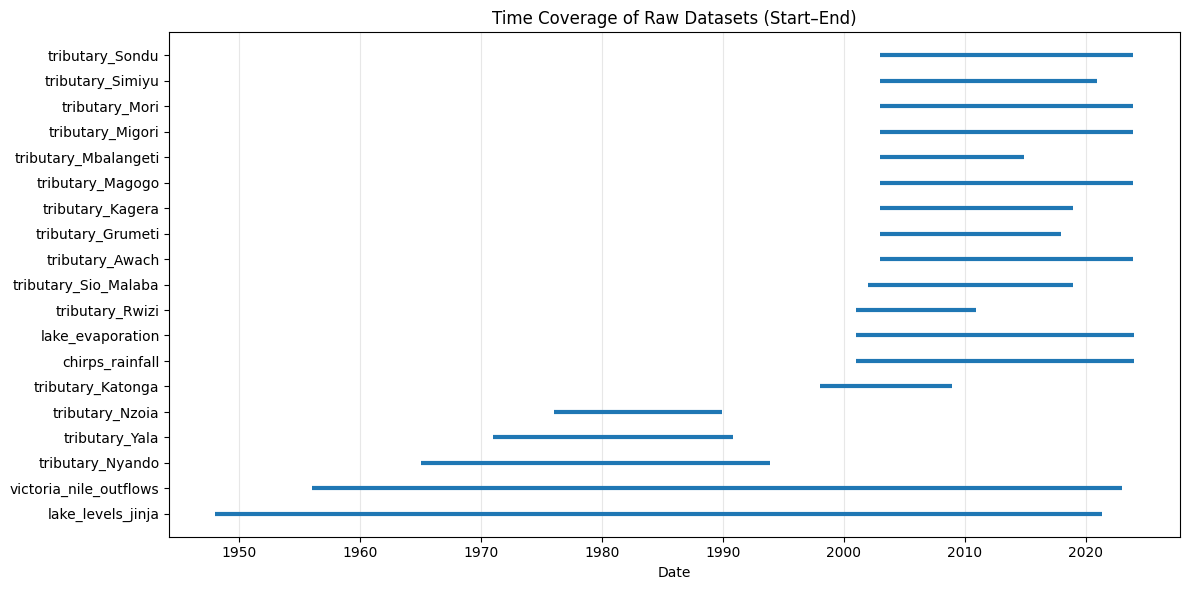

In [9]:
def plot_time_coverage(inventory_df: pd.DataFrame, outpath: Path) -> None:
    """Plot dataset start/end bars to show temporal overlap."""
    inv = inventory_df.copy().sort_values("start").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, max(6, 0.28 * len(inv))))
    y = np.arange(len(inv))

    starts = pd.to_datetime(inv["start"])
    ends = pd.to_datetime(inv["end"])

    ax.hlines(y=y, xmin=starts, xmax=ends, linewidth=3)
    ax.set_yticks(y)
    ax.set_yticklabels(inv["dataset"])
    ax.set_xlabel("Date")
    ax.set_title("Time Coverage of Raw Datasets (Start–End)")
    ax.grid(True, axis="x", alpha=0.3)

    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()


plot_time_coverage(inventory, FIG_DIR / "01_time_coverage.png")


### *Cell 9 — Compute common overlap period (core daily datasets)*

In [10]:
def common_overlap_period(inventory_df: pd.DataFrame, datasets: List[str]) -> Tuple[pd.Timestamp, pd.Timestamp]:
    """Compute common overlapping period across selected datasets."""
    subset = inventory_df[inventory_df["dataset"].isin(datasets)].copy()
    if subset.empty:
        raise ValueError("No datasets matched for overlap computation.")

    common_start = pd.to_datetime(subset["start"]).max()
    common_end = pd.to_datetime(subset["end"]).min()

    if common_end <= common_start:
        raise ValueError(
            "No valid overlap period found. Check date parsing or dataset coverage."
        )

    return common_start, common_end


core_daily = [
    "chirps_rainfall",
    "lake_evaporation",
    "victoria_nile_outflows",
    "lake_levels_jinja",
]

overlap_start, overlap_end = common_overlap_period(inventory, core_daily)
n_days = (overlap_end - overlap_start).days + 1

print("Common overlapping period for CORE DAILY datasets:")
print(f"Start: {overlap_start.date()} | End: {overlap_end.date()} | Days: {n_days:,}")


Common overlapping period for CORE DAILY datasets:
Start: 2001-01-01 | End: 2021-04-27 | Days: 7,422


### *Cell 10 & 11 — Build audit daily dataframe + heatmap*

In [11]:
def build_master_daily_frame(
    main_data_map: Dict[str, pd.DataFrame],
    start: pd.Timestamp,
    end: pd.Timestamp,
) -> pd.DataFrame:
    """Create a daily dataframe of core variables over the overlap period."""
    idx = pd.date_range(start=start, end=end, freq="D")
    out = pd.DataFrame(index=idx)

    out["rainfall_mm"] = (
        main_data_map["chirps_rainfall"]
        .reindex(idx)["Average_pcp_mm/day"]
    )

    out["evap_mm"] = (
        main_data_map["lake_evaporation"]
        .reindex(idx)["Daily_Evaporation_mm/day"]
    )

    out["outflow_m3s"] = (
        main_data_map["victoria_nile_outflows"]
        .reindex(idx)["Flow_cubic_metres/sec"]
    )

    out["lake_level_m"] = (
        main_data_map["lake_levels_jinja"]
        .reindex(idx)["Water_Level_m/day"]
    )

    return out


audit_daily = build_master_daily_frame(main_data, overlap_start, overlap_end)
audit_daily.to_csv(PROCESSED_DIR / "audit_daily_core_variables.csv", index=True)
audit_daily.tail()


,rainfall_mm,evap_mm,outflow_m3s,lake_level_m
2021-04-23,18.135666,4.84,2268.932,13.29
2021-04-24,5.652629,3.78,2196.108,13.29
2021-04-25,25.331071,1.40,2234.283,13.28
2021-04-26,5.575073,3.07,2249.929,13.30
2021-04-27,6.682059,4.68,2361.611,13.32


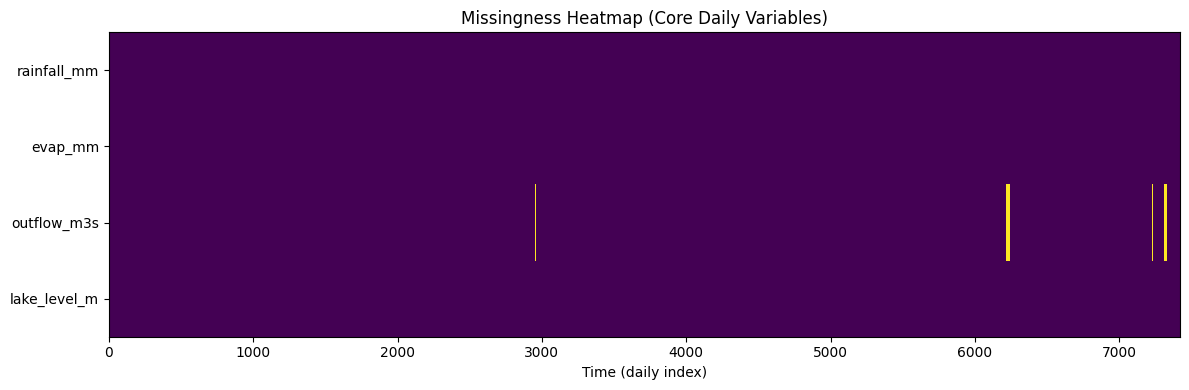

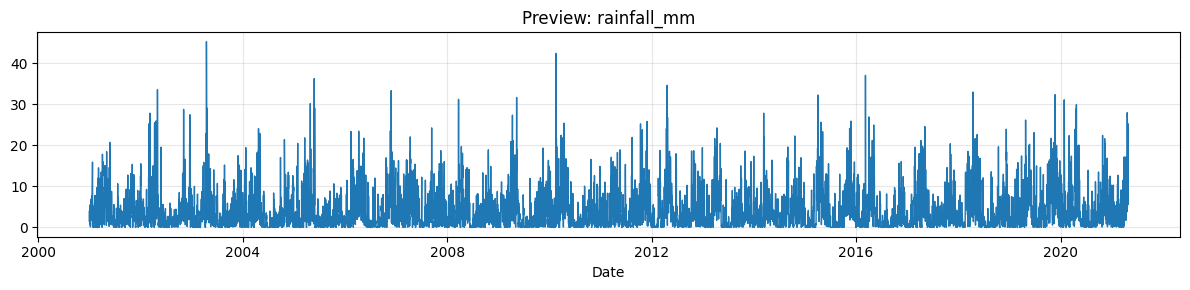

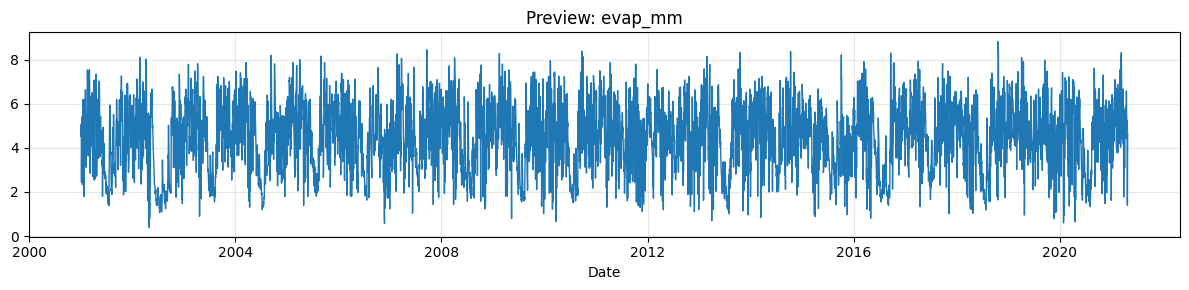

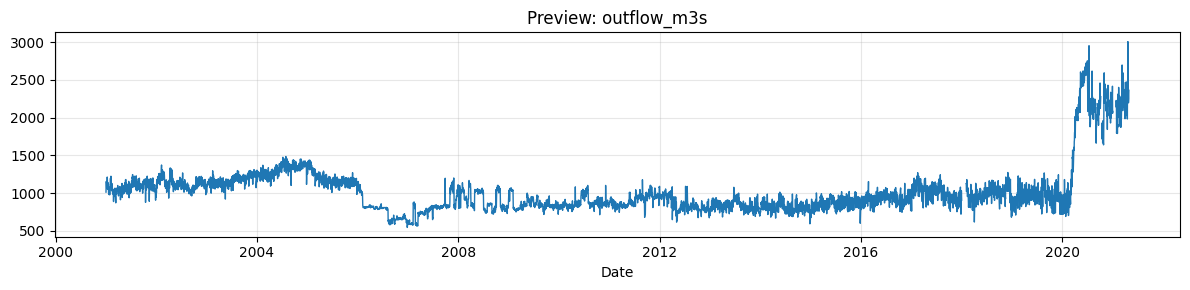

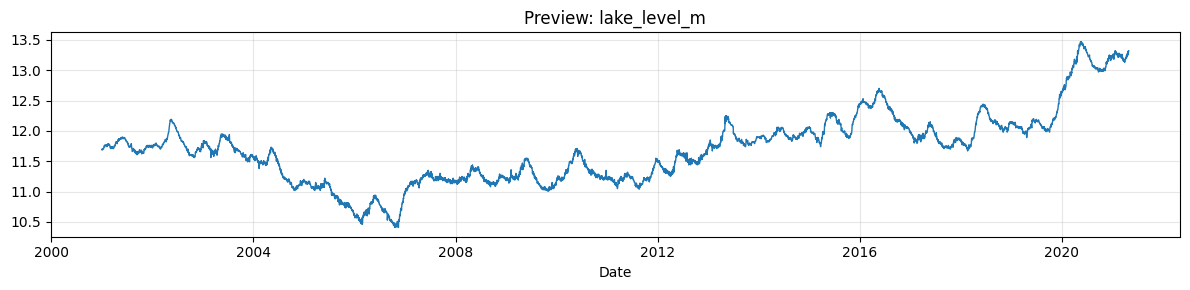

In [12]:
def plot_missingness_heatmap(df: pd.DataFrame, outpath: Path) -> None:
    """Plot missingness heatmap for the audit dataframe."""
    miss = df.isna()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.imshow(miss.T, aspect="auto", interpolation="nearest")
    ax.set_yticks(np.arange(df.shape[1]))
    ax.set_yticklabels(df.columns)
    ax.set_title("Missingness Heatmap (Core Daily Variables)")
    ax.set_xlabel("Time (daily index)")
    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()


def plot_quick_timeseries(df: pd.DataFrame, outdir: Path) -> None:
    """Plot quick previews for each variable."""
    for col in df.columns:
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.plot(df.index, df[col], linewidth=1)
        ax.set_title(f"Preview: {col}")
        ax.set_xlabel("Date")
        ax.grid(True, alpha=0.3)
        fig.tight_layout()
        fig.savefig(outdir / f"01_preview_{col}.png", dpi=200)
        plt.show()


plot_missingness_heatmap(audit_daily, FIG_DIR / "01_missingness_heatmap.png")
plot_quick_timeseries(audit_daily, FIG_DIR)


### *Cell 11 — Auto thesis-ready summary text (saved)*

In [13]:
def build_thesis_data_audit_summary(start: pd.Timestamp, end: pd.Timestamp) -> str:
    """Write a short thesis-ready paragraph summarizing the audit."""
    days = (end - start).days + 1
    text = (
        "A data inventory and quality audit was conducted for all hydro-meteorological inputs "
        "used in the Lake Victoria water balance and dam outflow optimization analysis. "
        "The core daily datasets comprised lake-average precipitation (CHIRPS), lake evaporation, "
        "Victoria Nile outflows at Jinja, and observed lake levels at Jinja pier. "
        f"The common overlapping period across these daily datasets was {start.date()} to {end.date()} "
        f"({days:,} days), and this period was adopted as the primary calibration and evaluation window "
        "for the lake water balance model. Tributary inflows were provided as time series for 15 tributaries "
        "and will be standardized, audited for gaps, and combined into total lake inflow during subsequent preprocessing."
    )
    return text


summary_text = build_thesis_data_audit_summary(overlap_start, overlap_end)
print(summary_text)

(TABLE_DIR / "01_data_audit_summary.txt").write_text(summary_text, encoding="utf-8")


A data inventory and quality audit was conducted for all hydro-meteorological inputs used in the Lake Victoria water balance and dam outflow optimization analysis. The core daily datasets comprised lake-average precipitation (CHIRPS), lake evaporation, Victoria Nile outflows at Jinja, and observed lake levels at Jinja pier. The common overlapping period across these daily datasets was 2001-01-01 to 2021-04-27 (7,422 days), and this period was adopted as the primary calibration and evaluation window for the lake water balance model. Tributary inflows were provided as time series for 15 tributaries and will be standardized, audited for gaps, and combined into total lake inflow during subsequent preprocessing.


716